# Image Matching and Homography Estimation with OpenCV and LightGlue

**LightGlue Repository:** https://github.com/cvg/LightGlue

In [1]:
### Uncomment and run the bottom two lines to install LightGlue!
### Restart kernel ("Run" -> "Restart & clear cell outputs") after installation!

#!git clone https://github.com/cvg/LightGlue.git 
#!python -m pip install -e LightGlue/

In [2]:
import cv2 
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from lightglue import viz2d
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd, numpy_image_to_torch
import CSRansac

In [3]:
import random
import math

    
def csransac(target_keypoint, frame_keypoint):

    # input: np.array([[t_x1,t_y1],[t_x2,t_y2],...]), np.array([[f_x1,f_y1],[f_x2,f_y2],...])
    # [t_x1,t_y1] 과 [f_x1,f_y1]은 매칭된 특징점.
    # 매칭된 특징점의 인덱스가 같아야함.

    homography = [[1,0,0],[0,1,0],[0,0,1]]
    best_homography = [[1,0,0],[0,1,0],[0,0,1]]
    if len(target_keypoint) < 6: # 매칭된 특징점의 수가 5개 이하일 경우 호모그래피를 추정할 수 없다고 판단.
        return np.array([[1,0,0],[0,1,0],[0,0,1]]), 0
    max_iteration = 1000
    iteration = 1000
    iteration_count = 0
    max_g = 1000
    p = 0.99
    s = 4
    best_inlier_rate = -1
    while 1:
        if iteration_count >= iteration:
            break
        elif iteration_count >= max_iteration:
            break
        satisfaction = False
        count = 0
        while satisfaction == False:
            target_sample = list()
            frame_sample = list()
            grid_list = list()
            for i in range(34):
                grid_list.append(-1)
            for i in range(4):
                count += 1
                if count > max_g:
                    for top_idx in range(4):
                        target_sample.append(target_keypoint[top_idx])
                        frame_sample.append(frame_keypoint[top_idx])
                    break
                idx = random.randint(0, len(target_keypoint)-1)
                target_sample.append(target_keypoint[idx])
                frame_sample.append(frame_keypoint[idx])
                col, row = get_position(frame_keypoint[idx])
                grid_list[row] = col
            #==================================================
            #CSP
            m_i = 0
            m_j = 0
            for i in range(34):
                m_i = i
                if (grid_list[i] == -1):
                    continue
                for j in range(34):
                    m_j = j
                    if i == j:
                        continue
                    if (grid_list[j] == -1):
                        continue
                    if grid_list[i] == grid_list[j]:
                        break
                    d = i - j
                    if (grid_list[i] == (grid_list[j] - d)) or (grid_list[i] == (grid_list[j] + d)):
                        break
                    if d == 1 or d == -1:
                        if grid_list[i] == grid_list[j] + 2 or grid_list[i] == grid_list[j] - 2:
                            break
                    if d == 2 or d == -2:
                        if grid_list[i] == grid_list[j] + 1 or grid_list[i] == grid_list[j] - 1:
                            break
                if m_j != 33:
                    break
            if m_i == 33:
                satisfaction = True
            #==================================================
        
        homography = find_homography(target_sample, frame_sample)
        inliers = calculate_inliers(homography, target_keypoint, frame_keypoint,5)
        inlier_rate = inliers / len(target_keypoint)
        if inlier_rate == 1:
            break
        if inlier_rate > best_inlier_rate:
            best_inlier_rate = inlier_rate
            best_homography = homography
        e = 1 - best_inlier_rate
        try:
            iteration = math.log(1.0 - p) / math.log(1.0 - math.pow(1.0 - e, s))
        except:
            iteration = iteration
        iteration_count += 1
    if best_inlier_rate <= 0.3: # best_inlier_rate <= 0.3 일 경우 호모그래피 추정에 실패했다고 판단.
        return np.array([[1,0,0],[0,1,0],[0,0,1]]), best_inlier_rate
    return best_homography, best_inlier_rate
	
def get_position(keypoint):
    col_size = 34 # csp ransac grid size
    row_size = 34 # csp ransac grid size
    col = int(keypoint[0] / (320 / col_size)) # 이미지 width=320
    row = int(keypoint[1] / (240 / row_size)) # 이미지 height=240
    if col == col_size:
        col -= 1
    if row == row_size:
        row -= 1
    return (col, row)
	
def perspective_transform(src, homo):
    w = homo[2, 0] * src[0] + homo[2, 1] * src[1] + homo[2, 2]
    x = (homo[0, 0] * src[0] + homo[0, 1] * src[1] + homo[0, 2]) / w
    y = (homo[1, 0] * src[0] + homo[1, 1] * src[1] + homo[1, 2]) / w
    return (x, y)

def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

def find_homography(src_points, dst_points):
    A = []
    for i in range(4):
        X, Y = src_points[i][0], src_points[i][1]
        x, y = dst_points[i][0], dst_points[i][1]
        A.append([-X, -Y, -1, 0, 0, 0, x*X, x*Y, x])
        A.append([0, 0, 0, -X, -Y, -1, y*X, y*Y, y])

    A = np.asarray(A)
    U, S, Vh = np.linalg.svd(A)
    L = Vh[-1, :] / Vh[-1, -1]
    H = L.reshape(3, 3)
    return H

def calculate_inliers(H, points1, points2, threshold):
    num_points = len(points1)
    points1_hom = np.concatenate([points1, np.ones((num_points, 1))], axis=1).T
    points2 = np.array(points2)
    estimates = np.dot(H, points1_hom)
    estimates /= estimates[2, :]
    errors = np.sqrt(np.sum((points2.T - estimates[:2, :]) ** 2, axis=0))
    inliers = np.sum(errors <= threshold)
    return inliers
    
def estimate_scale_change(old_points, new_points):
    old_center = np.mean(old_points, axis=0)
    new_center = np.mean(new_points, axis=0)
    old_dists = np.linalg.norm(old_points - old_center, axis=1)
    new_dists = np.linalg.norm(new_points - new_center, axis=1)
    return np.mean(new_dists) / np.mean(old_dists)

In [4]:
class cfg:
    img0 = "img0.jpg"
    img1 = "img1.jpg"
    
    size = (480, 640)
    interpolation = cv2.INTER_AREA
    
    lightglue = {
        "extractor": "SuperPoint", # SuperPoint, DISK
        "device": "cpu", # cpu, cuda
        "max_kpts": 2048,
        "homography": {
            "method": cv2.RANSAC,
            "ransacReprojThreshold": 3.0
        }
    }

In [5]:
def load_img(file, size, interpolation):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=interpolation)
    return img


def get_homography(src_pts, dst_pts, method, ransacReprojThreshold):
    homography, mask = cv2.findHomography(
        src_pts, 
        dst_pts, 
        method=method, 
        ransacReprojThreshold=ransacReprojThreshold
    )
    return homography, mask

def plot_two_imgs(img0, img1, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img0)
    axes[0].axis("off")
    axes[0].set_title(title)
    axes[1].imshow(img1)
    axes[1].axis("off")
    axes[1].set_title(title)
    plt.show()


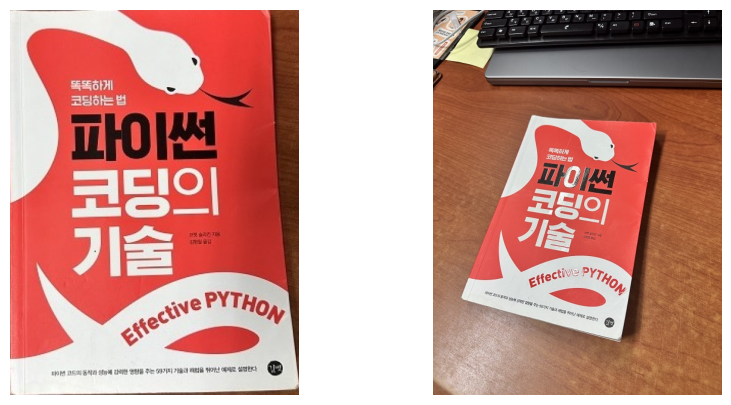

In [6]:
img0 = load_img(cfg.img0, size=cfg.size, interpolation=cfg.interpolation)
img1 = load_img(cfg.img1, size=cfg.size, interpolation=cfg.interpolation)

plot_two_imgs(img0, img1)

## LightGlue

In [7]:
def preprocess_lightglue(img):
    img = numpy_image_to_torch(img)
    return img


def match_lightglue(img0, img1, cfg):
    img0 = preprocess_lightglue(img0)
    img1 = preprocess_lightglue(img1)
    
    if cfg["extractor"] == "SuperPoint":
        extractor = SuperPoint(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])
        matcher = LightGlue(features='superpoint').eval().to(cfg["device"])

    # if cfg["extractor"] == "DISK":
    #     extractor = DISK(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])  # load the extractor
    #     matcher = LightGlue(features='disk').eval().to(cfg["device"])  # load the matcher

    # extract local features
    feats0 = extractor.extract(img0)  # auto-resize the image, disable with resize=None
    feats1 = extractor.extract(img1)
    
    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
    
    # get results
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = kpts0[matches[..., 0]]  # coordinates in img0, shape (K,2)
    points1 = kpts1[matches[..., 1]]  # coordinates in img1, shape (K,2)
        
    return {
        "points0": points0,
        "points1": points1,
        "matches01": matches01, 
        "matches": matches,
        "kpts0": kpts0,
        "kpts1": kpts1,
        "img0": img0,
        "img1": img1
    }


def visualize_lightglue(img0, img1, points0, points1, kpts0, kpts1, matches01, **kwargs):
    axes = viz2d.plot_images([img0, img1])
    viz2d.plot_matches(points0, points1, color='lime', lw=0.2)
    viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

    kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
    viz2d.plot_images([img0, img1])
    viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

CPU times: total: 27.5 s
Wall time: 4.34 s


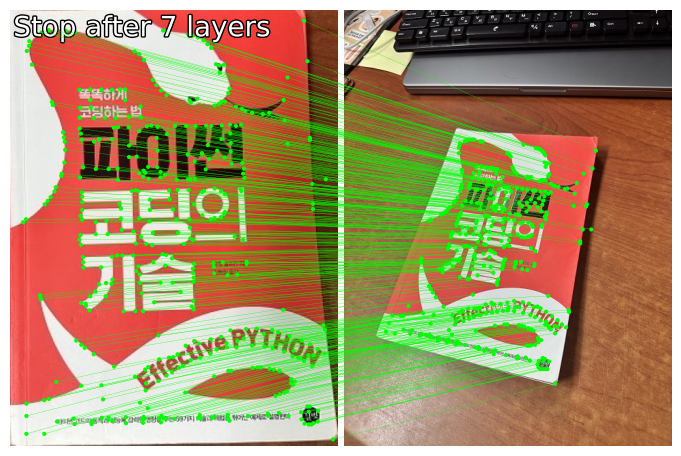

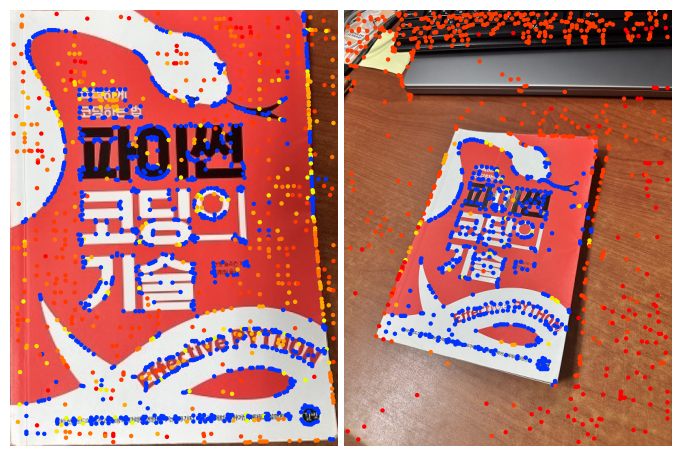

In [8]:
# LightGlue
%time results_lightglue = match_lightglue(img0, img1, cfg.lightglue)
visualize_lightglue(**results_lightglue)

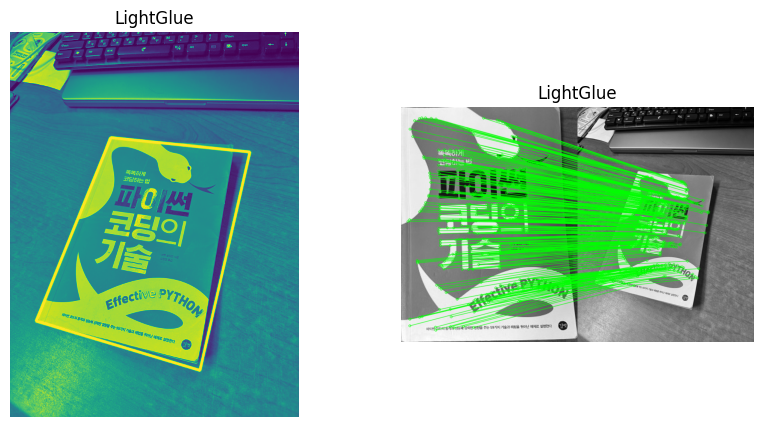

In [9]:
# img0 = load_image("img1.png")
# img1 = load_image("img2.png")

# # Visualize LightGlue results with OpenCV tools
# def lightglue2opencv(points0, points1, matches, kpts0, kpts1, img0, img1, **kwargs):
#     return {
#         "src_pts": points0.cpu().numpy().reshape(-1, 1, 2),
#         "dst_pts": points1.cpu().numpy().reshape(-1, 1, 2),
#         "kp0": cv2.KeyPoint_convert(kpts0.cpu().numpy()),
#         "kp1": cv2.KeyPoint_convert(kpts1.cpu().numpy()),
#         "matches": tuple(
#             cv2.DMatch(matches[i][0].item(), matches[i][1].item(), 0.) 
#             for i in range(matches.shape[0])
#         ),
#         "img0": cv2.cvtColor((255 * img0.cpu()).numpy().astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2GRAY),
#         "img1": cv2.cvtColor((255 * img1.cpu()).numpy().astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2GRAY)
#     }

# results_lightglue_opencv = lightglue2opencv(**results_lightglue)
# homography_lightglue = visualize_opencv(**results_lightglue_opencv, cfg=cfg.lightglue["homography"], title="LightGlue")

# Visualize LightGlue results with OpenCV tools
def lightglue2opencv(points0, points1, matches, kpts0, kpts1, img0, img1, **kwargs):
    return {
        "src_pts": points0.numpy().reshape(-1, 1, 2),
        "dst_pts": points1.numpy().reshape(-1, 1, 2),
        "kp0": cv2.KeyPoint_convert(kpts0.numpy()),
        "kp1": cv2.KeyPoint_convert(kpts1.numpy()),
        "matches": tuple(
            cv2.DMatch(matches[i][0].item(), matches[i][1].item(), 0.) 
            for i in range(matches.shape[0])
        ),
        "img0": cv2.cvtColor((255 * img0).numpy().astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2GRAY),
        "img1": cv2.cvtColor((255 * img1).numpy().astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2GRAY)
    }
    
    
def visualize_opencv(src_pts, dst_pts, kp0, kp1, matches, img0, img1, cfg, title="OpenCV", **kwargs):   
    homography, mask = get_homography(src_pts, dst_pts, cfg["method"], cfg["ransacReprojThreshold"])
    matches_mask = mask.ravel().tolist()
    
    # visualize mapping
    h, w = img0.shape[:2]
    pts = np.float32([[0, 0],[0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, homography)
    vis_mapping = cv2.polylines(img1.copy(), [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    # visualize matches
    draw_params = dict(
        matchColor = (0, 255, 0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matches_mask, # draw only inliers
        flags = 2
    )
    vis_matches = cv2.drawMatches(img0, kp0, img1, kp1, matches, None, **draw_params)
    
    # plot visualizations
    plot_two_imgs(vis_mapping, vis_matches, title=title)
    
    return homography


results_lightglue_opencv = lightglue2opencv(**results_lightglue)
homography_lightglue = visualize_opencv(**results_lightglue_opencv, cfg=cfg.lightglue["homography"], title="LightGlue")

## Compare Homography Matrices

In [10]:
homography_lightglue = homography_lightglue.round(2)
print("Lightglue:\n", homography_lightglue)

Lightglue:
 [[  0.38  -0.21 167.84]
 [ -0.     0.34 175.72]
 [ -0.    -0.     1.  ]]


test

In [11]:
img0 = cv2.imread("img0.jpg")
img1 = cv2.imread("img1.jpg")
#json 파일 읽기
with open('anno1.json', 'r') as f:
    json_data = json.load(f)

In [12]:
# coord = json_data["targetAnnotation"]
# x = float(coord[0])
# y = float(coord[1])
# width = img0.shape[1]
# height = img0.shape[0]
# x = int(x * width)
# y = int(y * height)

# #x, y좌표에 점 찍기
# cv2.circle(img0, (x, y), 5, (0, 0, 255), -1)
# cv2.imshow("img0", img0)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [13]:
# H = homography_lightglue
# source_coord = np.array([x, y, 1], dtype='int32')
# transformed_coord = H.dot(source_coord)
# transformed_coord = transformed_coord / transformed_coord[2]
# transformed_coord = transformed_coord.astype('int32')
# transformed_coord_2d = transformed_coord[:2].tolist()
# print(transformed_coord_2d)
# #img1 = cv2.resize(img1, (640, 480))
# #x, y좌표에 점 찍기
# cv2.circle(img1, transformed_coord_2d, 5, (0, 0, 255), -1)
# cv2.imshow("img1", img1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [14]:
transformed_img1 = cv2.warpPerspective(img0, homography_lightglue, (img0.shape[1], img0.shape[0]))

# cv2.circle(transformed_img1, (x, y), 10, (0, 0, 255), -1)
cv2.imshow("transformed", transformed_img1)
# #사진 저장
# cv2.imwrite("transformed_img1.png", transformed_img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
# doubled_transformed_coord = [x * 2 for x in transformed_coord_2d]
# print(transformed_coord_2d)